In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

import os
from tensorflow.keras.optimizers import RMSprop , Adam , Adamax , Adadelta
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras import Model
 
from tensorflow.keras.applications.vgg16 import VGG16
 
from tensorflow.keras.models import Model,Sequential
 
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,GlobalAveragePooling2D,Layer,Input,Lambda
from tensorflow.keras.optimizers import RMSprop , Adam , Adamax , Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
# re-size all the images to standard size 224 x 224
IMAGE_SIZE = [224, 224]

# specifying path for train and test data folders
train_path = 'C:/Ajay/documents/Major project/data/train'
valid_path = 'C:/Ajay/documents/Major project/data/test'

In [3]:
# Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator
# Addition of data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   rotation_range = 40,
                                   horizontal_flip = True)

In [4]:
# validation data should not be augmented
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('C:/Ajay/documents/Major project/data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('C:/Ajay/documents/Major project/data/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [5]:
from tensorflow.keras.models import load_model
vggmodel = load_model('vgg16.h5')

In [6]:
from keras import layers
from keras import models
from keras.layers import Input, Reshape, Lambda, Layer
from keras import backend as K
from keras.applications.vgg16 import VGG16

def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale

class Length(Layer):
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

# # Define the VGG16 model
# vggmodel = VGG16(weights='imagenet', include_top=False)

# # Freeze all the layers in the VGG16 model
# for layer in vggmodel.layers:
#     layer.trainable = False

# Define the input shape for the Capsule network
capsule_input = Input(shape=vggmodel.output_shape[1:])

# Reshape the input to match the output shape of the VGG16 model
capsule = Reshape((-1, vggmodel.output_shape[-1]))(capsule_input)

# Apply the squashing function
capsule = Lambda(squash)(capsule)

# Compute the length of each capsule
capsule = Length()(capsule)

# Create a model that combines the VGG16 and Capsule networks
capsmodel = models.Sequential()
capsmodel.add(vggmodel)
capsmodel.add(layers.Flatten())
capsmodel.add(layers.Dense(256, activation='relu'))
capsmodel.add(layers.Dense(2, activation='softmax'))

# Print the summary of the model
capsmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2)                 14846530  
_________________________________________________________________
flatten (Flatten)            (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 256)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 14,847,812
Trainable params: 133,124
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
from tensorflow.keras.utils import to_categorical
# Compile the model
capsmodel.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = capsmodel.fit(
        training_set,
        validation_data=test_set,
        batch_size=32,
        epochs= 10,
        verbose=1,
        steps_per_epoch=len(training_set),
        validation_steps=len(test_set),
                      )

Epoch 1/10
83/83 [==============================] - 36s 348ms/step - loss: 0.6481 - accuracy: 0.8221 - val_loss: 0.6142 - val_accuracy: 0.8409
Epoch 2/10
83/83 [==============================] - 24s 291ms/step - loss: 0.5851 - accuracy: 0.8297 - val_loss: 0.5521 - val_accuracy: 0.8439
Epoch 3/10
83/83 [==============================] - 25s 301ms/step - loss: 0.5326 - accuracy: 0.8229 - val_loss: 0.5024 - val_accuracy: 0.8439
Epoch 4/10
83/83 [==============================] - 25s 303ms/step - loss: 0.4874 - accuracy: 0.8237 - val_loss: 0.4732 - val_accuracy: 0.8182
Epoch 5/10
83/83 [==============================] - 25s 301ms/step - loss: 0.4499 - accuracy: 0.8331 - val_loss: 0.4344 - val_accuracy: 0.8424
Epoch 6/10
83/83 [==============================] - 25s 304ms/step - loss: 0.4267 - accuracy: 0.8278 - val_loss: 0.4096 - val_accuracy: 0.8500
Epoch 7/10
83/83 [==============================] - 25s 302ms/step - loss: 0.4074 - accuracy: 0.8331 - val_loss: 0.3924 - val_accuracy: 0.8500

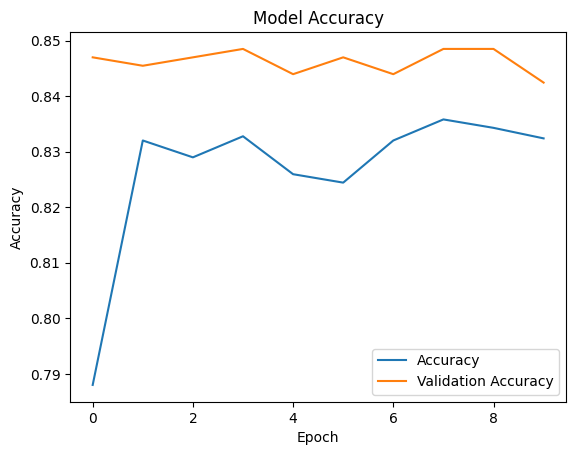

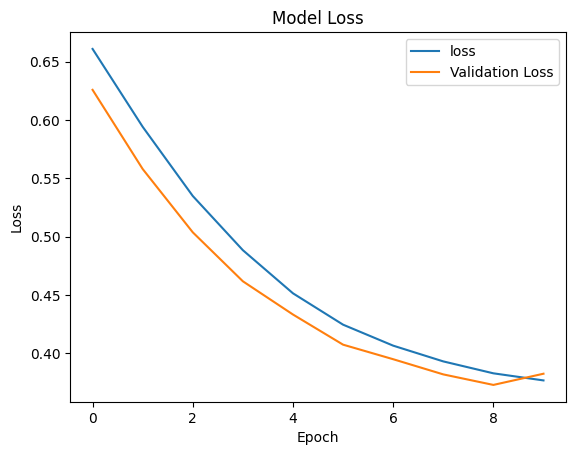

In [9]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

In [10]:
X_test, y_test = next(test_set)

In [11]:
print("Loss of the model is - " , capsmodel.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , capsmodel.evaluate(X_test,y_test)[1]*100 , "%")

1/1 [==============================] - 0s 288ms/step - loss: 0.2520 - accuracy: 0.9375
Loss of the model is -  0.25195449590682983
1/1 [==============================] - 0s 143ms/step - loss: 0.2520 - accuracy: 0.9375
Accuracy of the model is -  93.75 %


In [ ]:
from keras.models import load_model

# save the fine tuned model
capsmodel.save('capsnet.h5')